# Example: Two Double Gaussians

This notebook demonstrates fitting two peaks, each modeled as a double Gaussian (narrow core + wide component with shared mean).

In [1]:
from fitle import Param, gaussian, exponential, fit, Cost
import numpy as np
import matplotlib.pyplot as plt

## Generate Synthetic Data

Two peaks, each a double Gaussian.

In [2]:
np.random.seed(72)
# Peak 1: double gaussian at x=3
n1_core, n1_wide = 4000, 1000
mu1_true = 3.0
sigma1_core_true, sigma1_wide_true = 0.2, 0.6
# Peak 2: double gaussian at x=7
n2_core, n2_wide = 3000, 1500
mu2_true = 7.0
sigma2_core_true, sigma2_wide_true = 0.3, 0.8
# Background: exp
n_bkg = 2000
tau_true = 3.0  # decay constant
x_min, x_max = 0, 10  # data range

# Generate
data = np.concatenate([
    np.random.normal(mu1_true, sigma1_core_true, n1_core),
    np.random.normal(mu1_true, sigma1_wide_true, n1_wide),
    np.random.normal(mu2_true, sigma2_core_true, n2_core),
    np.random.normal(mu2_true, sigma2_wide_true, n2_wide),
    x_min - tau_true * np.log(1 - np.random.uniform(0, 1 - np.exp(-(x_max - x_min)/tau_true), n_bkg)),  # truncated exp
])
print(f"Total events: {len(data)}")

Total events: 11500


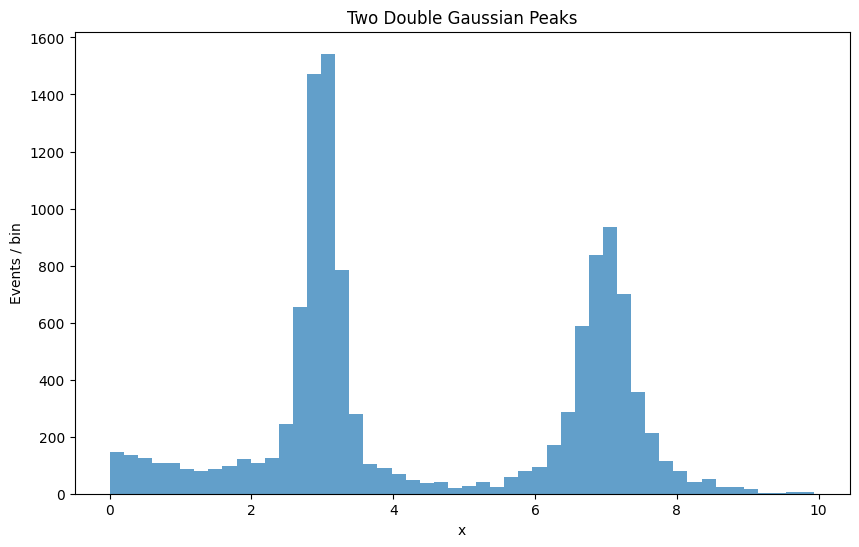

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(data, bins=50, alpha=0.7)
plt.xlabel('x')
plt.ylabel('Events / bin')
plt.title('Two Double Gaussian Peaks')
plt.show()

## Building the Model

Each peak is a double Gaussian: $N_{core} \cdot G(\mu, \sigma_{core}) + N_{wide} \cdot G(\mu, \sigma_{wide})$

In [25]:
# Peak 1: double gaussian with shared mean
mu1 = Param(0, 5)
sigma1_core, sigma1_wide = +Param, +Param
N1_core, N1_wide = +Param, +Param

peak1 = N1_core * gaussian(mu=mu1, sigma=sigma1_core) + \
        N1_wide * gaussian(mu=mu1, sigma=sigma1_wide)

# Peak 2: double gaussian
mu2 = Param(5, 10)
sigma2_core, sigma2_wide = +Param, +Param
N2_core, N2_wide = +Param, +Param

peak2 = N2_core * gaussian(mu=mu2, sigma=sigma2_core) + \
        N2_wide * gaussian(mu=mu2, sigma=sigma2_wide)

# Background
tau, N_background = (+Param)(3), +Param
background = N_background * exponential(tau)

# Full model
model = peak1 + peak2 + background

print(f"Parameters: {[p.name for p in model.params]}")
print(f"\nModel: {model}")

Parameters: ['N1_core', 'sigma1_core', 'mu1', 'N1_wide', 'sigma1_wide', 'N2_core', 'sigma2_core', 'mu2', 'N2_wide', 'sigma2_wide', None, None]

Model: N1_core=1 * (1 / (sigma1_core=1 * 2.5066282746310002) * exp(-0.5 * ((INPUT - mu1=2.5) / sigma1_core=1) ** 2)) + N1_wide=1 * (1 / (sigma1_wide=1 * 2.5066282746310002) * exp(-0.5 * ((INPUT - mu1=2.5) / sigma1_wide=1) ** 2)) + (N2_core=1 * (1 / (sigma2_core=1 * 2.5066282746310002) * exp(-0.5 * ((INPUT - mu2=7.5) / sigma2_core=1) ** 2)) + N2_wide=1 * (1 / (sigma2_wide=1 * 2.5066282746310002) * exp(-0.5 * ((INPUT - mu2=7.5) / sigma2_wide=1) ** 2))) + 1 * (1 / 3 * exp(-INPUT / 3))


## Fitting

In [27]:
cost = Cost.chi2(data, bins=50)

fit_result = fit(model | cost)
fit_result

<FitResult fval=57.937, success=True>
N1_core: 4146 ± 1e+02
sigma1_core: 0.219 ± 0.0045
mu1: 3.001 ± 0.004
N1_wide: 1191 ± 2.1e+02
sigma1_wide: 0.8057 ± 0.1
N2_core: 1678 ± 1.3e+02
sigma2_core: 0.8538 ± 0.066
mu2: 6.997 ± 0.0068
N2_wide: 2978 ± 1.6e+02
sigma2_wide: 0.3055 ± 0.011
x10: 1458 ± 3.3e+02
x11: 1.865 ± 0.56

## Plotting Results

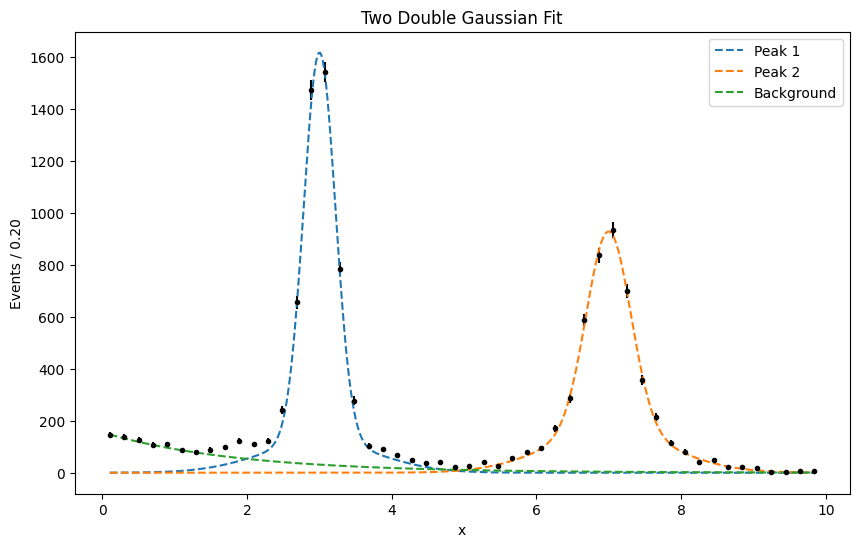

In [30]:
plt.figure(figsize=(10, 6))

fit_result.plot_data()

x = np.linspace(fit_result.x.min(), fit_result.x.max(), 500)
bw = fit_result.bin_width

plt.plot(x, peak1(x) * bw, '--', label='Peak 1')
plt.plot(x, peak2(x) * bw, '--', label='Peak 2')
plt.plot(x, background(x) * bw, '--', label='Background')

plt.xlabel('x')
plt.ylabel(f'Events / {bw:.2f}')
plt.title('Two Double Gaussian Fit')
plt.legend()
plt.show()

## Fit Results

In [32]:
print("=== Peak 1 ===")
print(f"mu1: {fit_result.values['mu1']:.3f} ± {fit_result.errors['mu1']:.3f} (true: {mu1_true})")
print(f"N1_core: {fit_result.values['N1_core']:.0f}, N1_wide: {fit_result.values['N1_wide']:.0f}")
print(f"sigma1_core: {fit_result.values['sigma1_core']:.3f}, sigma1_wide: {fit_result.values['sigma1_wide']:.3f}")

print("\n=== Peak 2 ===")
print(f"mu2: {fit_result.values['mu2']:.3f} ± {fit_result.errors['mu2']:.3f} (true: {mu2_true})")
print(f"N2_core: {fit_result.values['N2_core']:.0f}, N2_wide: {fit_result.values['N2_wide']:.0f}")
print(f"sigma2_core: {fit_result.values['sigma2_core']:.3f}, sigma2_wide: {fit_result.values['sigma2_wide']:.3f}")

=== Peak 1 ===
mu1: 3.001 ± 0.004 (true: 3.0)
N1_core: 4146, N1_wide: 1191
sigma1_core: 0.219, sigma1_wide: 0.806

=== Peak 2 ===
mu2: 6.997 ± 0.007 (true: 7.0)
N2_core: 1678, N2_wide: 2978
sigma2_core: 0.854, sigma2_wide: 0.305
